## Imports

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Load Data

In [4]:
images,labels = [],[]
count = 0

for filename in os.listdir('train'):
    if count >= 5000:
        break

    if filename.endswith(".jpeg"):
        images.append(os.path.join('train', filename))
        label = filename.replace('.jpeg', '').split('/')[-1]
        labels.append(label)
        count += 1

## Display Sample data

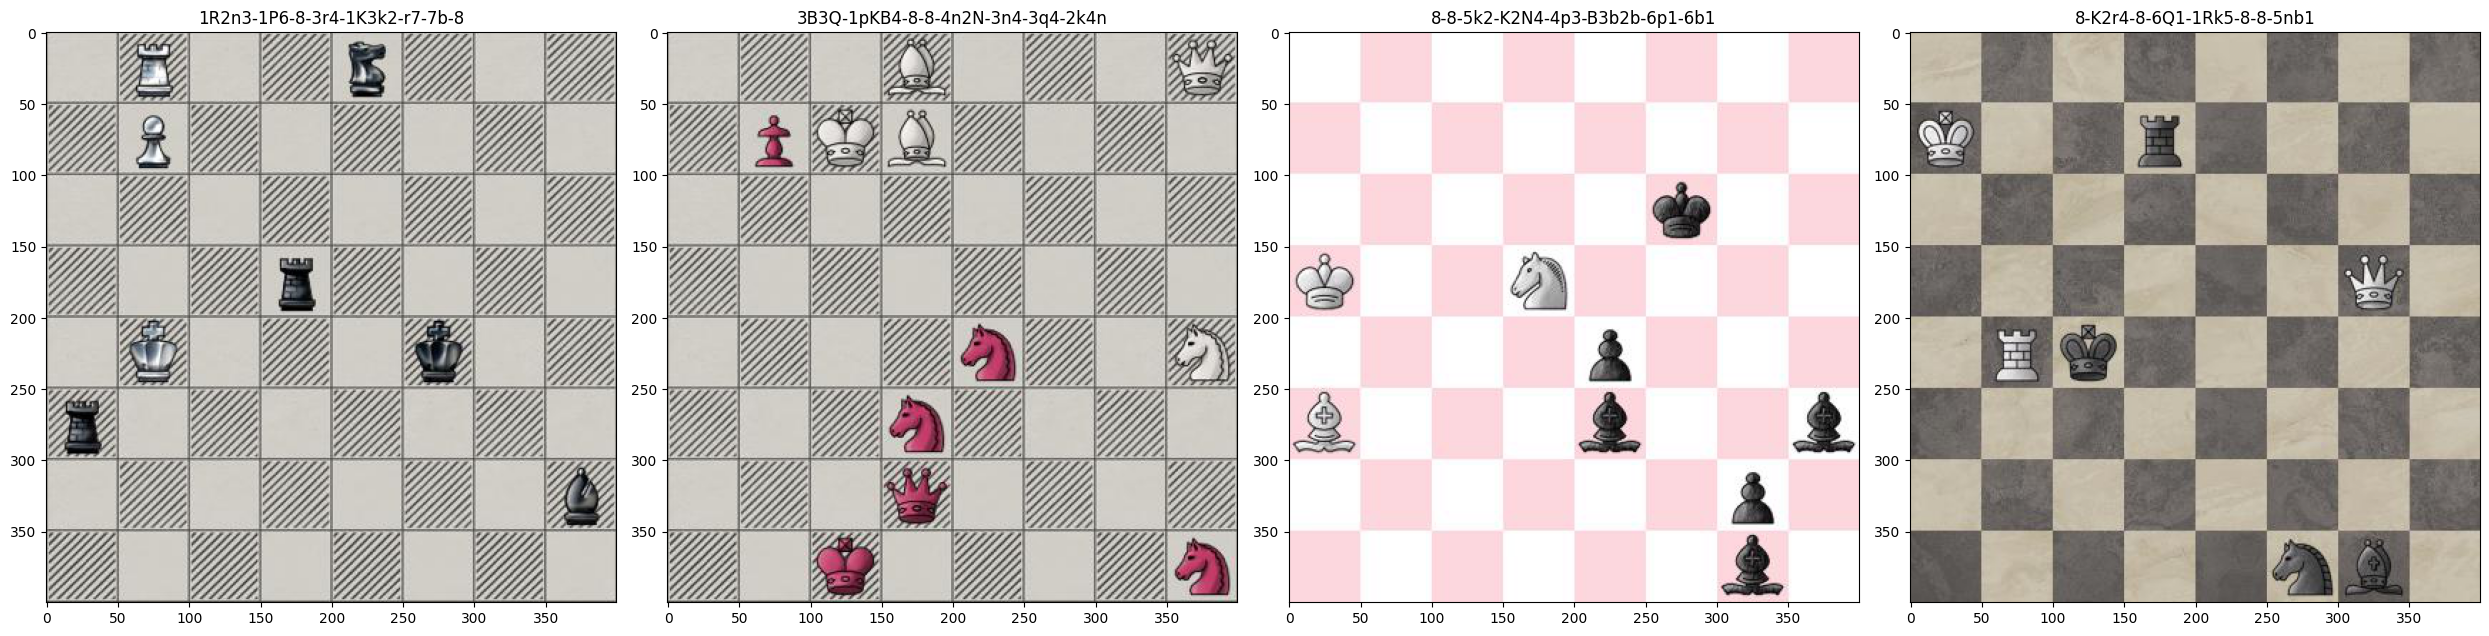

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 10))
unique_labels = np.unique(labels)
label_counts = {label: 0 for label in unique_labels}

for i, ax in enumerate(axes.flat):
    if i >= len(images):
        break

    label = labels[i]
    if label_counts[label] == 2:
        continue
    label_counts[label] += 1

    image_path = images[i]
    image = plt.imread(image_path)
    ax.imshow(image)
    ax.set_title(label)

plt.tight_layout()
plt.show()


## Process Images and Labels

In [6]:
def image_process(image):
    size = int(200/8)
    img_read = io.imread(image)
    img_read = transform.resize(
      img_read, (200, 200), mode='constant')
    img_p = view_as_blocks(img_read, block_shape=(size, size, 3))
    img_p = img_p.squeeze(axis=2)
    img_p.reshape(64, size, size, 3)
    return img_p

### **` The above image_process function resizes the input image to a fixed size of 200x200 pixels, divides it into smaller square tiles, and returns a 4-dimensional Numpy array representing the chessboard with 64 square tiles for further processing by a machine learning model. `**

In [7]:
def to_onehot(fen, piece_symbols = 'prbnkqPRBNKQ'):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)
    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)
    return output

### **`The to_onehot function takes a FEN (Forsyth-Edwards Notation) string representing a chess position and converts it into a one-hot encoded representation. The function uses NumPy's eye function to create an identity matrix for the 13 possible pieces (including empty squares) on a chessboard. It then iterates through the FEN string, assigning one-hot encoded vectors to each square based on the presence of pieces or the number of consecutive empty squares. The function returns a Numpy array representing the one-hot encoded FEN position.`**

In [8]:
def preprocess(image_paths, labels):
    processed_images = []
    processed_labels = []
    i = 0
    for image_ in image_paths:
        processed_image = image_process(image_)
        processed_images.append(processed_image)
        processed_labels.append(to_onehot(labels[i]))
        i += 1

    processed_images = np.array(processed_images)
    processed_labels = np.array(processed_labels)
    return processed_images, processed_labels

In [9]:
X, y = preprocess(images, labels)

## Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Reshaping for training and testing

In [11]:
X_train_ = X_train.reshape(-1, 25, 25, 3)
X_val = X_val.reshape(-1, 25, 25, 3)

y_train_ = y_train.reshape(-1, 13)
y_val = y_val.reshape(-1, 13)

In [12]:
X_test_ = X_test.reshape(-1, 25, 25, 3)
y_test_ = to_categorical(y_test, num_classes=13)

## Model Building and Training

In [13]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(25, 25, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(13, activation='softmax'))

### **` The model is a convolutional neural network (CNN) designed for chess position recognition (FEN). 
### It consists of multiple convolutional layers with increasing filter sizes, followed by batch normalization and max-pooling layers for downsampling. 
### Dropout layers are incorporated for regularization to prevent overfitting. 
### The model uses fully connected layers with ReLU activation functions to learn higher-level features and ends with a softmax activation to predict one of the 13 possible FEN positions. 
### This architecture is suitable for image classification tasks and balances complexity and performance effectively.` **

In [14]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = model.fit(X_train_, y_train_, batch_size=16, epochs=5, validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/5
12800/12800 [==============================] - 225s 17ms/step - loss: 0.0977 - accuracy: 0.9733 - val_loss: 0.0013 - val_accuracy: 0.9997 - lr: 0.0010
Epoch 2/5
12800/12800 [==============================] - 222s 17ms/step - loss: 0.0132 - accuracy: 0.9965 - val_loss: 6.8162e-04 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 3/5
12800/12800 [==============================] - 218s 17ms/step - loss: 0.0078 - accuracy: 0.9979 - val_loss: 1.5186e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 4/5
12800/12800 [==============================] - 216s 17ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 4.9519e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/5
12800/12800 [==============================] - 218s 17ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0020 - val_accuracy: 0.9996 - lr: 0.0010


### **` The model is trained for 5 epochs on the training data (X_train_ and y_train_) with a batch size of 16 and validated on the validation data (X_val and y_val).` **

## Evaluation

***`I have choosen Accuracy and Classification Report. 
Accuracy offers a high-level overview of the model's overall performance, while the classification report gives class-specific performance, helping identify any variations in accuracy across different FEN positions.
Together, they provide a comprehensive understanding of how well the model is classifying FEN positions and which classes might require further attention or improvement.`***

In [23]:
from sklearn.metrics import classification_report
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy,report

In [24]:
y_test_ = to_categorical(y_test, num_classes=13)
y_pred_probabilities = model.predict(X_test_)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

y_pred_ = to_categorical(y_pred_labels, num_classes=13)

accuracy, report = evaluate(model, X_test_, y_pred_)

2000/2000 [==============================] - 14s 7ms/step


In [25]:
print(f"Accuracy of the model: {accuracy}")

Accuracy of the model: 1.0


In [28]:
print(f"Classification Report of the model: {report}")

Classification Report of the model:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       877
           1       1.00      1.00      1.00       891
           2       1.00      1.00      1.00       918
           3       1.00      1.00      1.00       878
           4       1.00      1.00      1.00       991
           5       1.00      1.00      1.00       501
           6       1.00      1.00      1.00       963
           7       1.00      1.00      1.00       898
           8       1.00      1.00      1.00       875
           9       1.00      1.00      1.00       875
          10       1.00      1.00      1.00      1000
          11       1.00      1.00      1.00       459
          12       1.00      1.00      1.00     53874

    accuracy                           1.00     64000
   macro avg       1.00      1.00      1.00     64000
weighted avg       1.00      1.00      1.00     64000



## Accuracy and Loss Plots

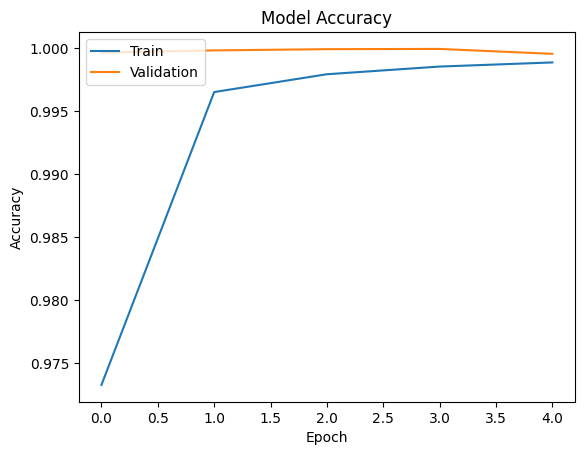

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

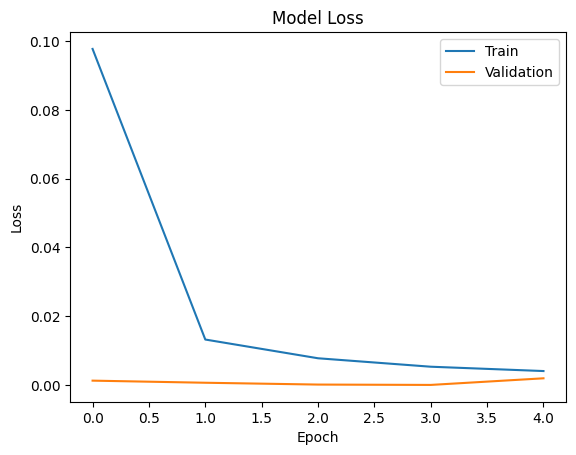

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [19]:
model.save('Chess_model_v1.h5')

/Users/kiruba/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
